<a href="https://colab.research.google.com/github/fernvndafifi/data-police-shootings/blob/master/EII4220_Proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ANÁLISIS DESCRIPTIVO Y PREDICTIVO SOBRE LOS TIROTEOS FATALES POR POLICÍAS EN ESTADOS UNIDOS**

---


En los últimos años, los tiroteos fatales realizados por policías en Estados Unidos han generado una atención significativa, debido a su impacto en la sociedad y sus implicaciones en la seguridad pública. La creciente preocupación por los incidentes relacionados con el uso excesivo de la fuerza ha resaltado la necesidad de una comprensión más profunda y detallada de los patrones subyacentes en estos eventos trágicos.

Este proyecto tiene como objetivo identificar qué departamentos de policía en EE.UU. presentan mayores índices de tiroteos fatales. La propuesta se basa en la premisa de que un análisis exhaustivo de datos históricos puede ofrecer insights cruciales para abordar y mitigar estos incidentes. Para ello, se emplearán modelos avanzados de machine learning (ML) que permitirán examinar y entender las variables y factores que contribuyen a la ocurrencia de tiroteos fatales.

Además del análisis descriptivo, se desarrollará un modelo predictivo con el fin de anticipar los departamentos con mayor riesgo de futuros tiroteos fatales. Este enfoque proactivo no solo busca comprender los eventos pasados, sino también prever y prevenir futuros incidentes, ofreciendo una herramienta valiosa para las autoridades y responsables de políticas en la formulación de estrategias de intervención y prevención efectivas.

In [ ]:
#Importación de clases
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Cargar las bases de datos
uploaded = files.upload()
data1 = pd.read_excel('fatal-police-shootings-agencies.xlsx')
data2 = pd.read_excel('fatal-police-shootings-data.xlsx')
data3 = pd.read_excel('cities-of-USA-info.xlsx', usecols=['State (full name)', 'State'])

data1.rename(columns={'id': 'agency_id', 'name': 'agency_name'}, inplace=True)
data2.rename(columns={'agency_ids': 'agency_id'}, inplace=True)
data3.rename(columns={'State': 'state'}, inplace=True)

# Unir los datos
Data = pd.merge(data1, data2, on=["agency_id", "state"])
data = pd.merge(Data, data3, on=["state"])

# Eliminar posibles duplicados que tengan los mismos valores en columnas clave, excepto el nombre
data = data.drop_duplicates(subset=['agency_id', 'id', 'date', 'gender'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saving cities-of-USA-info.xlsx to cities-of-USA-info (5).xlsx
Saving fatal-police-shootings-agencies.xlsx to fatal-police-shootings-agencies (5).xlsx
Saving fatal-police-shootings-data.xlsx to fatal-police-shootings-data (3).xlsx


In [ ]:
#Mostrar data por pantalla
print(data)

       agency_id                 agency_name          type state   oricodes  \
0           2114   Abilene Police Department  local_police    TX    TX22101   
254         2114   Abilene Police Department  local_police    TX    TX22101   
508         2114   Abilene Police Department  local_police    TX    TX22101   
762         2114   Abilene Police Department  local_police    TX    TX22101   
1016        2114   Abilene Police Department  local_police    TX    TX22101   
...          ...                         ...           ...   ...        ...   
449799      1346  Honolulu Police Department  local_police    HI    HI00200   
449804      1346  Honolulu Police Department  local_police    HI    HI00200   
449809      1346  Honolulu Police Department  local_police    HI    HI00200   
449814       695      Maui Police Department  local_police    HI    HI00500   
449819      3613       U.S. Marshals Service       federal    HI  HIUSM0100   

        total_shootings     id       date threat_ty

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#1. Clasificación de variables
variable_types = {
    'agency_id': 'Nominal', #Identificador único de la agencia
    'agency_name': 'Nominal', #Nombre de la agencia
    'type': 'Nominal', #Tipo de agencia (sheriff, local_police, etc.)
    'state': 'Nominal', #Estado en el que se encuentra la agencia
    'oricodes': 'Nominal', #Código relacionado con la agencia
    'total_shootings': 'Razón', #Número total de tiroteos
    'id': 'Nominal', #Identificador único del incidente
    'date': 'Intervalo', #Fecha del tiroteo
    'threat_type': 'Nominal', #Tipo de amenaza (e.g., point, move)
    'flee_status': 'Nominal', #Estado de fuga (e.g., not, fled)
    'armed_with': 'Nominal', #Tipo de arma con la que estaba armado (e.g., gun, replica)
    'city': 'Nominal', #Ciudad donde ocurrió el tiroteo
    'county': 'Nominal', #Condado donde ocurrió el tiroteo
    'latitude': 'Razón', #Latitud del lugar del tiroteo
    'longitude': 'Razón', #Longitud del lugar del tiroteo
    'location_precision': 'Nominal', #Precisión de la ubicación
    'name': 'Nominal', #Nombre de la persona involucrada
    'age': 'Razón', #Edad de la persona involucrada
    'gender': 'Nominal', #Género de la persona involucrada
    'race': 'Nominal', #Raza de la persona involucrada
    'race_source': 'Nominal', #Fuente de la información sobre la raza
    'was_mental_illness_related': 'Nominal', #Relación del tiroteo con alguna enfermedad mental
    'body_camera': 'Nominal', #Existencia de cámara corporal
    'agency_id': 'Nominal', #Identificador de la agencia
    'state': 'Nominal', #Estado de la agencia
    'State (full name)': 'Nominal', #Nombre completo del estado
}

print("Clasificación de Variables:")
for var, tipo in variable_types.items():
    print(f"{var}: {tipo}")

#2. Análisis univariado: resumen descriptivo de las variables numéricas
print("")
summary = data.describe()
print(summary)

# Frecuencia de variables categóricas
categorical_columns = ['agency_id', 'agency_name', 'type', 'state', 'oricodes', 'threat_type',
                       'flee_status', 'armed_with', 'city', 'county', 'location_precision',
                       'gender', 'race', 'race_source', 'was_mental_illness_related',
                       'body_camera', 'State (full name)']

print("")
for col in categorical_columns:
    print(f"\nFrecuencia de {col}:\n", data[col].value_counts())


Clasificación de Variables:
agency_id: Nominal
agency_name: Nominal
type: Nominal
state: Nominal
oricodes: Nominal
total_shootings: Razón
id: Nominal
date: Intervalo
threat_type: Nominal
flee_status: Nominal
armed_with: Nominal
city: Nominal
county: Nominal
latitude: Razón
longitude: Razón
location_precision: Nominal
name: Nominal
age: Razón
gender: Nominal
race: Nominal
race_source: Nominal
was_mental_illness_related: Nominal
body_camera: Nominal
State (full name): Nominal

       total_shootings            id                           date  \
count      5207.000000   5207.000000                           5207   
mean         19.241214   4116.635683  2018-09-13 01:09:58.041098752   
min           1.000000      3.000000            2015-01-02 00:00:00   
25%           2.000000   1656.500000            2016-06-19 00:00:00   
50%           7.000000   3171.000000            2017-11-23 00:00:00   
75%          23.000000   5209.500000            2019-10-07 00:00:00   
max         141.000000 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
Index: 5207 entries, 0 to 449819
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   agency_id                   5207 non-null   object        
 1   agency_name                 5207 non-null   object        
 2   type                        5207 non-null   object        
 3   state                       5207 non-null   object        
 4   oricodes                    5148 non-null   object        
 5   total_shootings             5207 non-null   int64         
 6   id                          5207 non-null   int64         
 7   date                        5207 non-null   datetime64[ns]
 8   threat_type                 5189 non-null   object        
 9   flee_status                 4859 non-null   object        
 10  armed_with                  5022 non-null   object        
 11  city                        5195 non-null   object        


<ipython-input-30-cecdf6038fdd>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


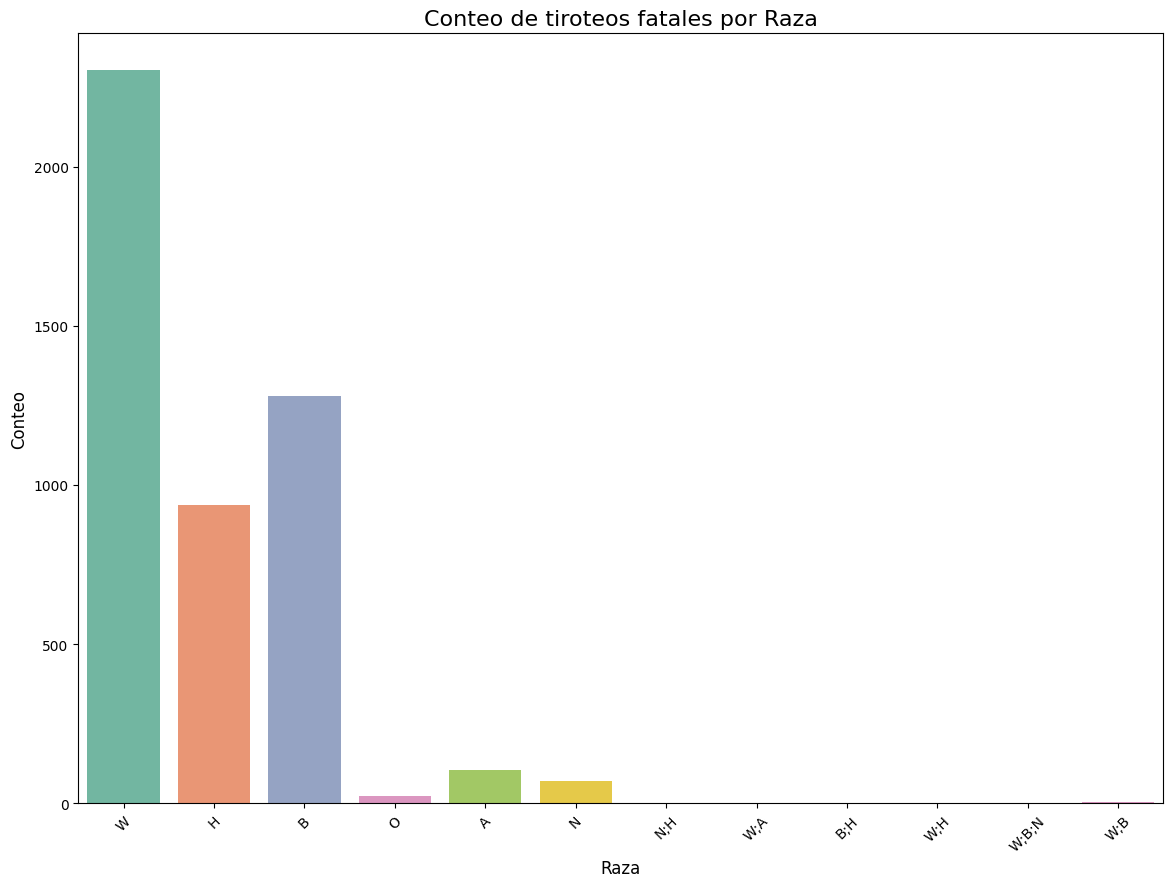

<ipython-input-30-cecdf6038fdd>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


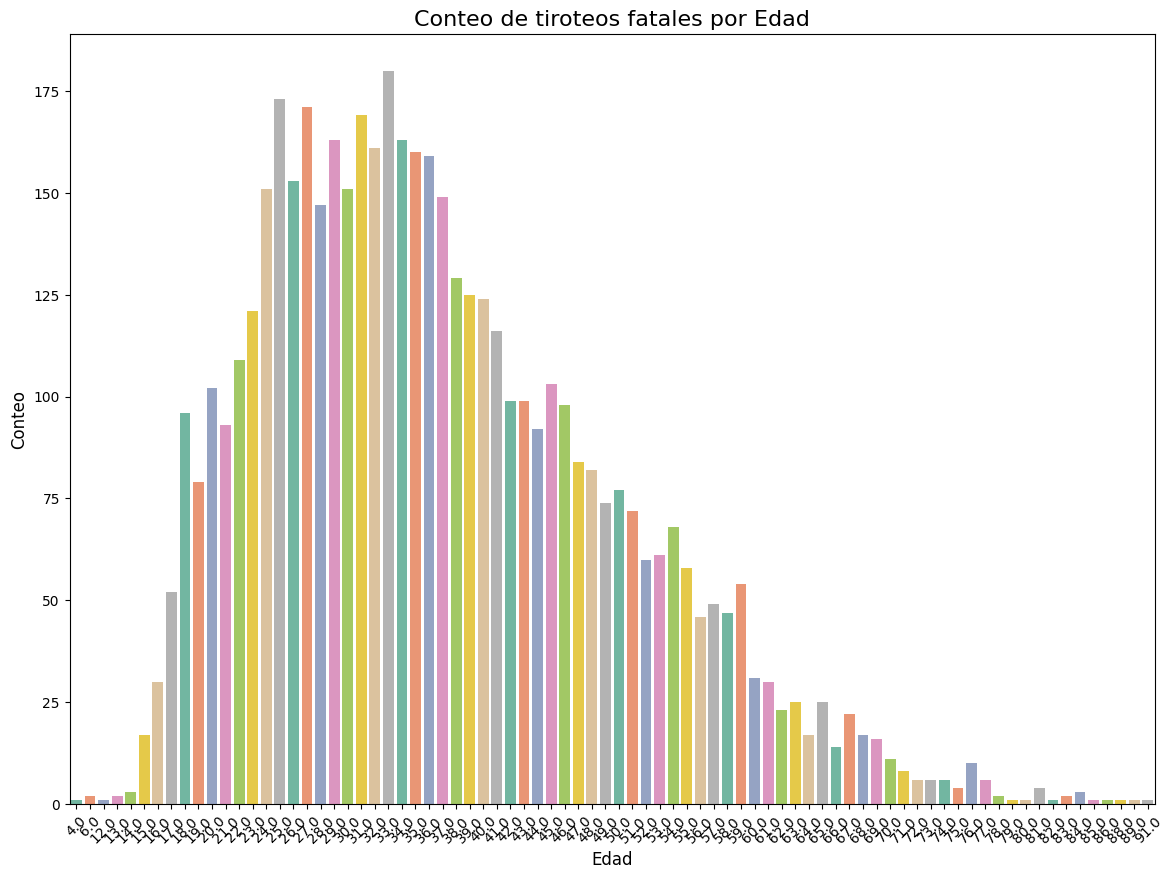

<ipython-input-30-cecdf6038fdd>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


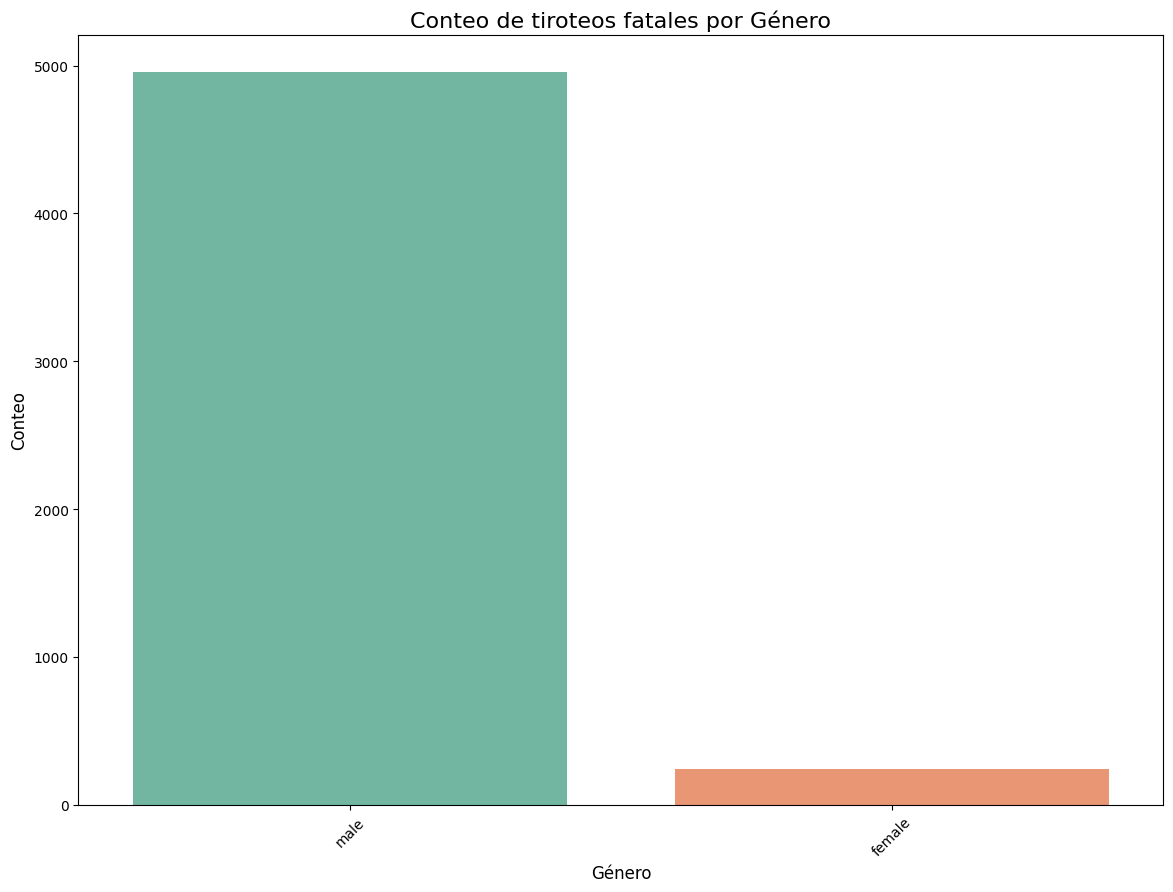

<ipython-input-30-cecdf6038fdd>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


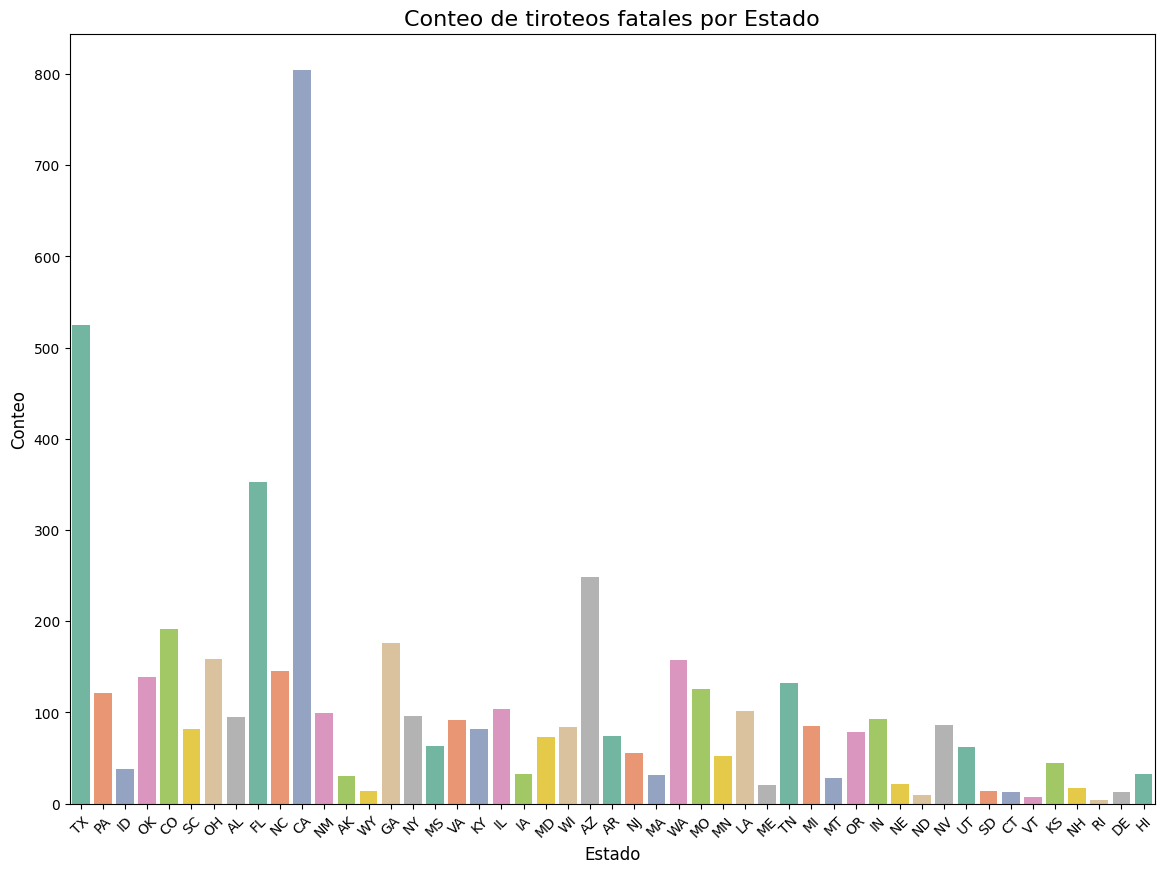

<ipython-input-30-cecdf6038fdd>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shootings_per_year.index, y=shootings_per_year.values, palette='Set2')


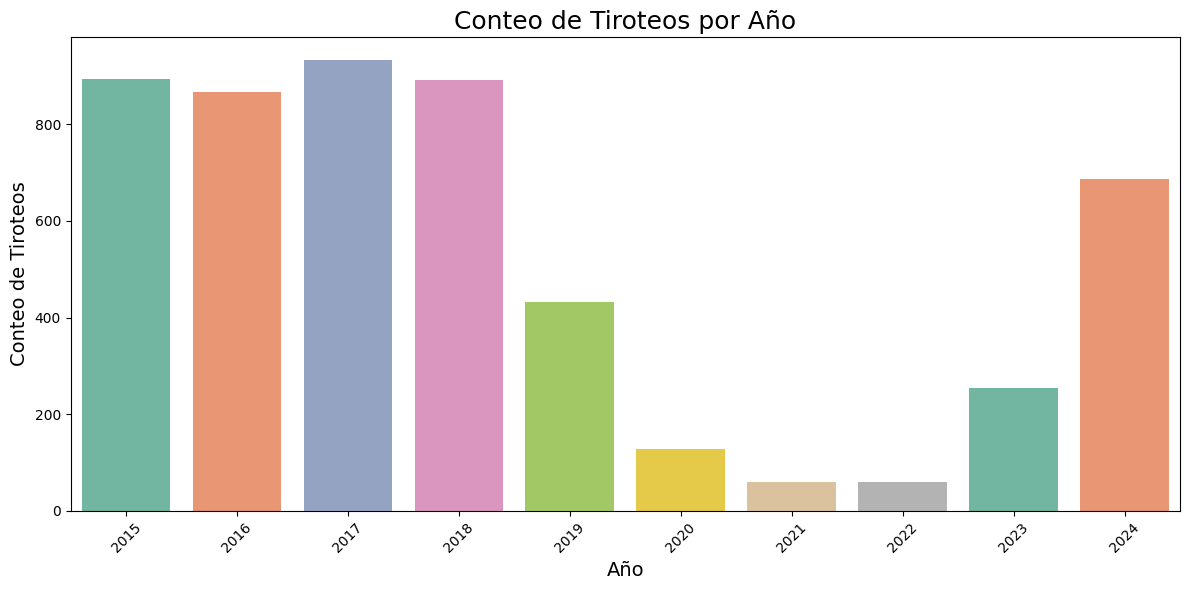

<ipython-input-30-cecdf6038fdd>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=category_column, y=value_column, data=data, palette='Set2')


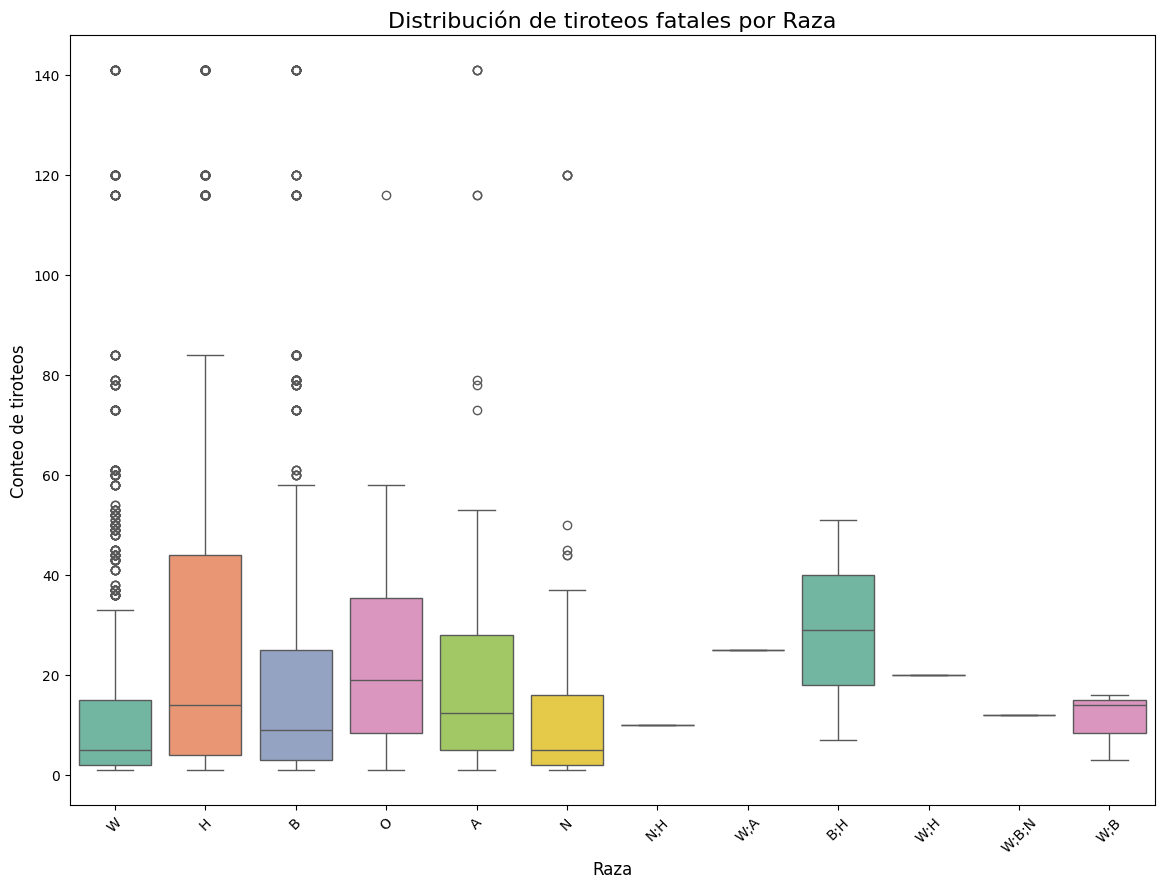

<ipython-input-30-cecdf6038fdd>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=category_column, y=value_column, data=data, palette='Set2')


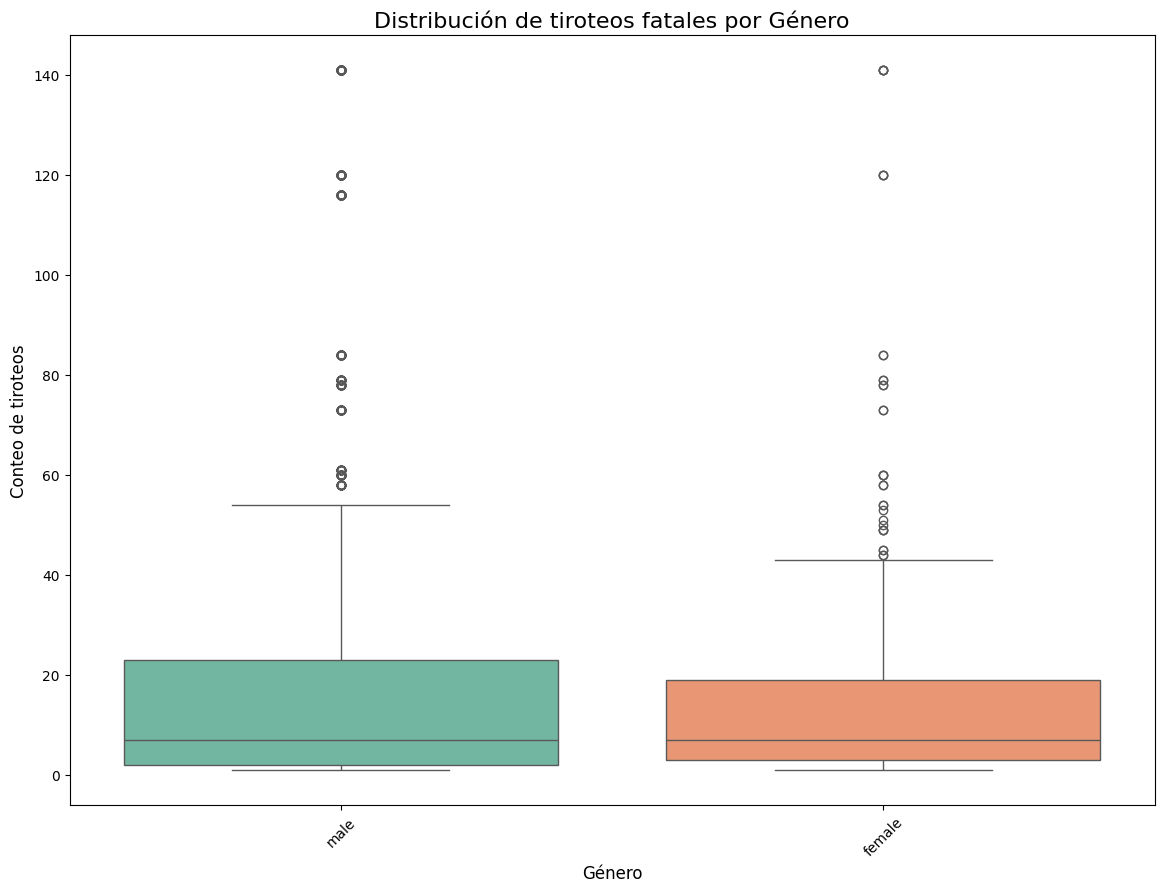

<ipython-input-30-cecdf6038fdd>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=category_column, y=value_column, data=data, palette='Set2')


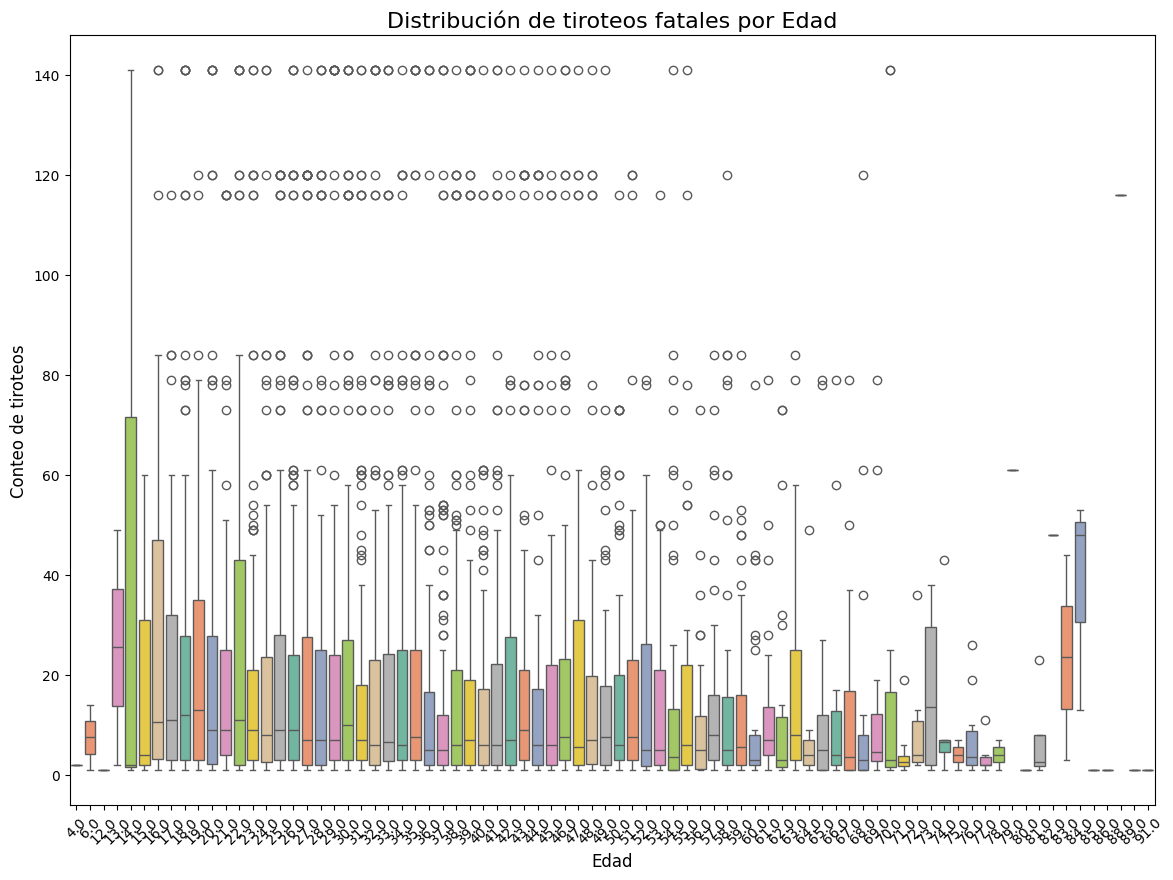

<ipython-input-30-cecdf6038fdd>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=category_column, y=value_column, data=data, palette='Set2')


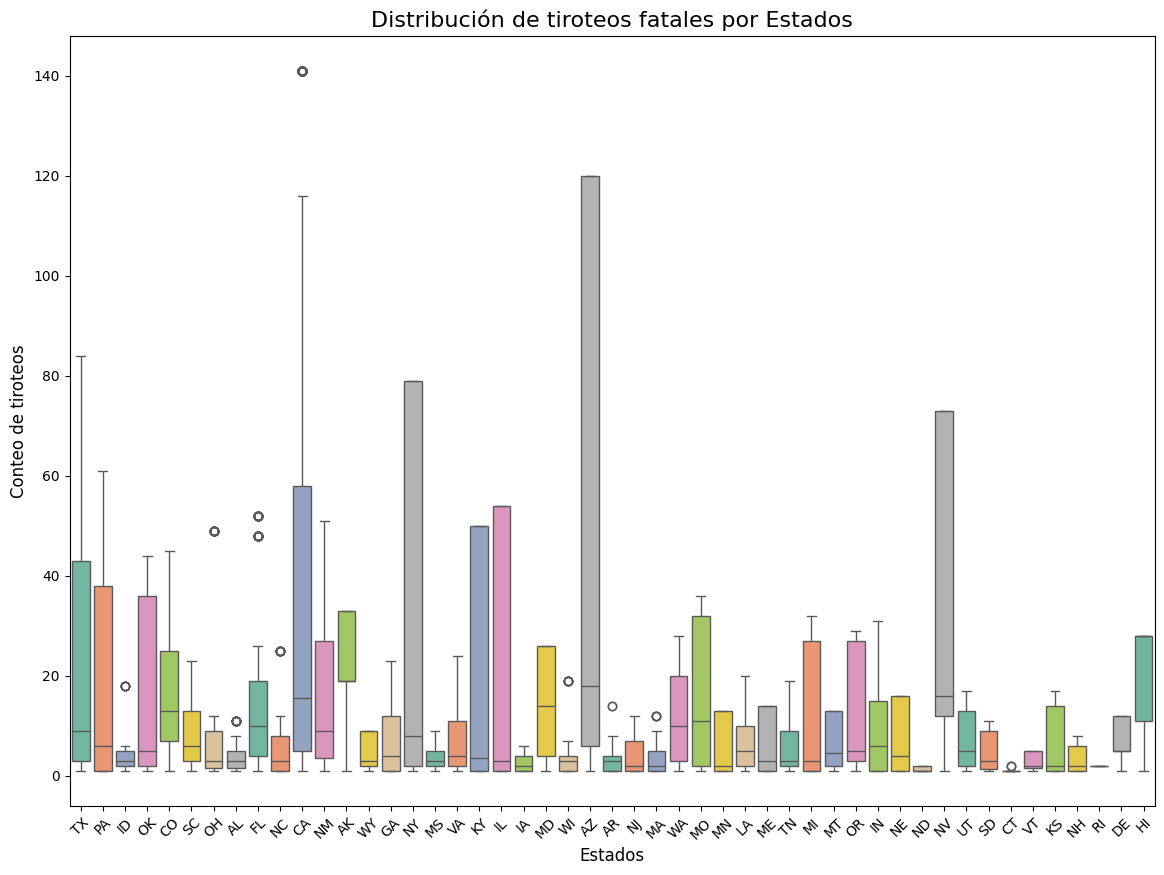

In [ ]:
#GRÁFICAS ASOCIADAS: Dispersión y de barras
#GRÁFICAS DE BARRAS (considerando el estado de la data actual)
data_info = data.info()
print(data_info)

#Función para crear gráficos de barras para cualquier columna categórica
def plot_category_count(data, column, title):
    if column in data.columns:
        plt.figure(figsize=(14, 10))
        sns.countplot(x=column, data=data, palette='Set2')
        plt.title(f'Conteo de tiroteos fatales por {title}', fontsize=16)
        plt.xlabel(title, fontsize=12)
        plt.ylabel('Conteo', fontsize=12)
        plt.xticks(rotation=45)
        plt.show()
    else:
        print(f"La columna '{column}' no se encuentra en el DataFrame.")

#Convertir fecha a formato fecha (aseguramiento de los datos)
data['date'] = pd.to_datetime(data['date'], errors='coerce')

#Crear una nueva columna con el año, para generar las gráficas
data['year'] = data['date'].dt.year

#Función para agregar una variable de 'año' en el dataframe
def plot_shootings_per_year(data):
    shootings_per_year = data['year'].value_counts().sort_index()
    plt.figure(figsize=(12, 6))
    sns.barplot(x=shootings_per_year.index, y=shootings_per_year.values, palette='Set2')
    plt.title('Conteo de Tiroteos por Año', fontsize=18)
    plt.xlabel('Año', fontsize=14)
    plt.ylabel('Conteo de Tiroteos', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#Gráfico 1: Conteo de tiroteos fatales por raza
plot_category_count(data, 'race', 'Raza')

#Gráfico 2: Conteo de tiroteos fatales por edad
plot_category_count(data, 'age', 'Edad')

#Gráfico 3: Conteo de tiroteos fatales por género
plot_category_count(data, 'gender', 'Género')

#Gráfico 4: Conteo de tiroteos fatales por estados
plot_category_count(data, 'state', 'Estado')

#Gráfico 5: Conteo de tiroteos fatales por año
plot_shootings_per_year(data)

#GRÁFICAS BOXPLOT (considerando el estado de la data actual)
def boxplot_category_count(data, category_column, value_column, title):
    if category_column in data.columns and value_column in data.columns:
        plt.figure(figsize=(14, 10))
        sns.boxplot(x=category_column, y=value_column, data=data, palette='Set2')
        plt.title(f'Distribución de tiroteos fatales por {title}', fontsize=16)
        plt.xlabel(title, fontsize=12)
        plt.ylabel(f'Conteo de tiroteos', fontsize=12)
        plt.xticks(rotation=45)
        plt.show()
    else:
        print(f"Una de las columnas '{category_column}' o '{value_column}' no se encuentra en el DataFrame.")


def boxplot_shootings_per_year(data):
    if 'year' in data.columns:
        shootings_per_year = data['year'].value_counts().sort_index()
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=shootings_per_year.index, y=shootings_per_year.values, palette='Set2')
        plt.title('Conteo de Tiroteos por Año', fontsize=18)
        plt.xlabel('Año', fontsize=14)
        plt.ylabel('Conteo de Tiroteos', fontsize=14)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("La columna 'year' no se encuentra en el DataFrame.")

#GRÁFICA 1: Conteo de tiroteos por raza
boxplot_category_count(data,'race','total_shootings','Raza')

#GRÁFICA 2: Conteo de tiroteos por género
boxplot_category_count(data,'gender','total_shootings','Género')

#GRÁFICA 3: Conteo de tiroteos por edad
boxplot_category_count(data,'age','total_shootings','Edad')

#GRÁFICA 4: Conteo de tiroteos por estado
boxplot_category_count(data,'state','total_shootings','Estados')